##**BITS F464 - Semester 1 - MACHINE LEARNING**
--------------------------------------------------------------------------------

**ASSIGNMENT 1 - LINEAR MODELS FOR REGRESSION AND CLASSIFICATION**
--------------------------------------------------------------------------------
***Team number:***

---
(*In Title case, separated with commas*)
***Full names of all students in the team:***

---
(*Separated by commas*)
***Id number of all students in the team:***


This assignment aims to identify the differences between three sets of Machine Learning models.

# **_1. Dataset Generation_**

You are given a sample Diabetes dataset. Using this, please develop your own dataset consisting of 500 records. You can use the given code to generate your own dataset. Submit the generated dataset as a .csv file along with your python notebook.

In [1]:
%pip install sdv
# Uninstall the existing urllib3 version
!pip uninstall urllib3

# Install the required urllib3 version
!pip install urllib3==1.26.7


Found existing installation: urllib3 1.26.7
Uninstalling urllib3-1.26.7:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/urllib3-1.26.7.dist-info/*
    /usr/local/lib/python3.10/dist-packages/urllib3/*
Proceed (Y/n)? y
  Successfully uninstalled urllib3-1.26.7
  Using cached urllib3-1.26.7-py2.py3-none-any.whl (138 kB)


In [2]:
from google.colab import files

# Optional: You can skip this step if you are running the code on your own
# machine
uploaded = files.upload()

Saving diabetes2.csv to diabetes2.csv


In [3]:
import pandas as pd

In [4]:
from sdv.datasets.local import load_csvs
from sdv.datasets.demo import download_demo

# This is the default folder name that the GOogle Colab notebook uses.
# Change this if you have your own folder with CSV files.
FOLDER_NAME = 'content/'

try:
  datasets = load_csvs(folder_name='/content/')
except ValueError:
  print('You have not uploaded any csv files. Using some demo data instead.')
  datasets, _ = download_demo(
    modality='multi_table',
    dataset_name='fake_hotels'
  )

In [5]:
datasets.keys()

dict_keys(['diabetes2'])

In [6]:
diabetes2_table = datasets['diabetes2']

# use the head method to inspect the first few rows of the data
diabetes2_table.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [7]:
from sdv.metadata import MultiTableMetadata

metadata = MultiTableMetadata()

In [8]:
metadata.detect_from_dataframes(
    data=datasets
)

Auto detected data:



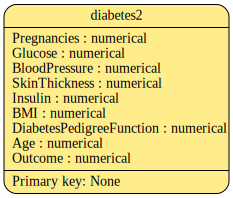

In [9]:
print('Auto detected data:\n')
metadata.visualize()

In [10]:
metadata.validate()

In [11]:
metadata.validate_data(data={
    'diabetes2': diabetes2_table,
})

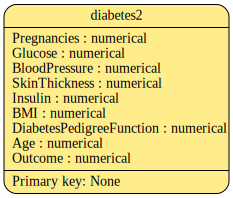

In [12]:
metadata.visualize()

In [13]:
metadata.save_to_json('metadata.json')

# in the future, you can reload the metadata object from the file
metadata = MultiTableMetadata.load_from_json('metadata.json')

In [14]:
from sdv.multi_table import HMASynthesizer

synthesizer = HMASynthesizer(metadata)
synthesizer.fit(datasets)
synthetic_data = synthesizer.sample(scale=1)

Preprocess Tables: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]



Learning relationships:



Modeling Tables: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


In [15]:
synthetic_data['diabetes2'].head(505).to_csv('first_500_values.csv', index=False)

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


# ***2. Preprocess and perform exploratory data analysis of the dataset obtained***

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Load the dataset from the CSV file
diabetes_df = pd.read_csv('first_500_values.csv')
from sklearn import preprocessing
sx = preprocessing.MinMaxScaler()
sy = preprocessing.MinMaxScaler()

scaled_X = sx.fit_transform(diabetes_df.drop('Outcome',axis='columns'))
scaled_y = sy.fit_transform(diabetes_df['Outcome'].values.reshape(diabetes_df.shape[0],1))


#Preprocessing for Stochastic gradient descent
#This is called Z-score normalization or standardization
# Standardize the features
def standardize_features(X_train, X_test):
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_train_scaled = (X_train - mean) / std
    X_test_scaled = (X_test - mean) / std
    return X_train_scaled, X_test_scaled

scaled_X


array([[0.23529412, 0.53333333, 0.7012987 , ..., 0.48533333, 0.31822917,
        0.46666667],
       [0.        , 0.68      , 0.24675325, ..., 0.31466667, 0.39375   ,
        0.01666667],
       [0.        , 0.70666667, 0.37662338, ..., 0.33866667, 0.07552083,
        0.33333333],
       ...,
       [0.35294118, 0.34      , 0.50649351, ..., 0.864     , 0.21197917,
        0.25      ],
       [0.58823529, 0.51333333, 0.37662338, ..., 0.31733333, 0.17708333,
        0.36666667],
       [0.        , 0.26      , 0.31168831, ..., 0.39466667, 0.0671875 ,
        0.01666667]])

# ***3. Comparison of Stochastic Gradient Descent and Batch Gradient Descent using Linear Regression***

## **_Stochastic Gradient Descent_**

In [17]:
import numpy as np
import pandas as pd

# Load the dataset from the CSV file
diabetes_df = pd.read_csv('first_500_values.csv')

# Split the dataset into features (X) and target variable (y)
X = diabetes_df.drop('Outcome', axis=1).values
y = diabetes_df['Outcome'].values

# Split the data into training and testing sets
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    num_samples = X.shape[0]
    num_test_samples = int(test_size * num_samples)
    test_indices = np.random.choice(num_samples, num_test_samples, replace=False)
    train_indices = np.setdiff1d(np.arange(num_samples), test_indices)

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)



X_train_scaled, X_test_scaled = standardize_features(X_train, X_test)

# Stochastic Gradient Descent (SGD) for Linear Regression
def stochastic_gradient_descent(X, y, learning_rate=0.01, epochs=1000, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    num_samples, num_features = X.shape
    w = np.ones(num_features)  # Initialize weights with ones
    b = 0  # Initialize bias with zero

    for epoch in range(epochs):
        for i in range(num_samples):
            random_index = np.random.randint(num_samples)
            xi = X[random_index]
            yi = y[random_index]
            predicted_y = np.dot(w, xi) + b

            w_grad = -2 * xi * (yi - predicted_y)
            b_grad = -2 * (yi - predicted_y)

            w -= learning_rate * w_grad
            b -= learning_rate * b_grad

    return w, b

# Train the model using SGD
w_sgd, b_sgd = stochastic_gradient_descent(X_train_scaled, y_train, learning_rate=0.01, epochs=1000, random_state=0)

# Predict using the trained model
y_pred_sgd = np.dot(X_test_scaled, w_sgd) + b_sgd

# Calculate Mean Squared Error for SGD
mse_sgd = np.mean((y_test - y_pred_sgd) ** 2)
print(f"Mean Squared Error (SGD): {mse_sgd:.2f}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mean Squared Error (SGD): 0.06


In [20]:
import numpy as np
import pandas as pd

# ... (previous code)

# Define a threshold for converting continuous predictions to binary (0 or 1)
threshold = 0.5

# Predict using the trained model
y_pred_sgd_test = np.dot(X_test_scaled, w_sgd) + b_sgd
y_pred_sgd_train = np.dot(X_train_scaled, w_sgd) + b_sgd

# Convert continuous predictions to binary (0 or 1) using the threshold
y_pred_binary_test = (y_pred_sgd_test >= threshold).astype(int)
y_pred_binary_train = (y_pred_sgd_train >= threshold).astype(int)

# Define a function to calculate accuracy and precision
def calculate_accuracy_precision(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (TP + TN) / (TP + TN + FP + FN)


    return accuracy

# Calculate accuracy and precision
accuracy_test = calculate_accuracy_precision(y_test, y_pred_binary_test)
accuracy_train =  calculate_accuracy_precision(y_train, y_pred_binary_train)

# Print the results
print(f"Accuracy test: {accuracy_test:.2f}")
print(f"Accuracy train: {accuracy_train:.2f}")





Accuracy test: 0.94
Accuracy train: 0.92


## **_Insights drawn (plots, markdown explanations)_**

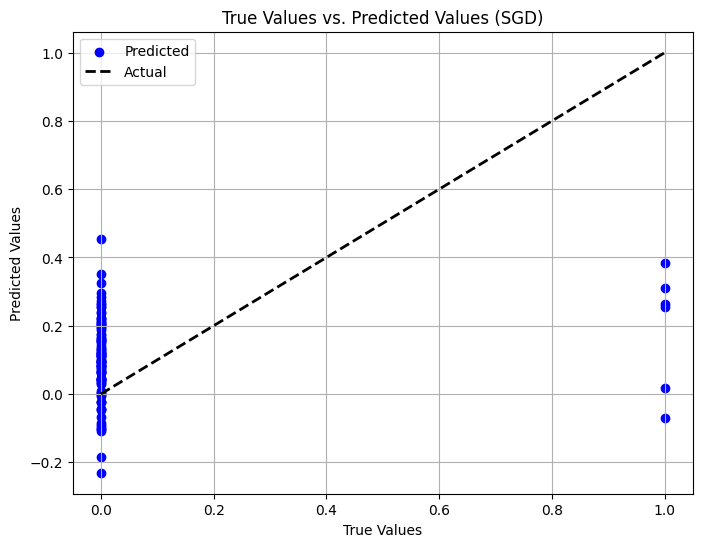

In [ ]:
import matplotlib.pyplot as plt
# Plot the predicted values against the true values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_sgd, c='b', marker='o', label='Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label='Actual')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True Values vs. Predicted Values (SGD)')
plt.legend()
plt.grid(True)
plt.show()

## **_Batch Gradient Descent_**

In [21]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

# Load the dataset from the CSV file
df = pd.read_csv('first_500_values.csv')

# Split the data into training and testing sets
def custom_train_test_split(data, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    num_samples = len(data)
    num_test_samples = int(test_size * num_samples)

    # Shuffle the data
    shuffled_data = data.sample(frac=1, random_state=random_state)

    # Split into training and testing
    train_data = shuffled_data.iloc[num_test_samples:]
    test_data = shuffled_data.iloc[:num_test_samples]

    return train_data, test_data

train_df, test_df = custom_train_test_split(df, test_size=0.2, random_state=0)

# Define your batch gradient descent function (similar to your previous code)
def batch_grad_des(x, y, epochs, alpha=0.01):
    no_of_features = x.shape[1]
    w = np.ones(shape=(no_of_features))
    b = 0
    tot_samples = x.shape[0]
    cost_list = []
    epoch_list = []

    for i in range(epochs):
        predicted_y = np.dot(w, x.T) + b
        w_grad = -(2 / tot_samples) * (x.T.dot(y - predicted_y))
        b_grad = -(2 / tot_samples) * np.sum(y - predicted_y)

        w = w - alpha * w_grad
        b = b - alpha * b_grad

        cost = np.mean(np.square(y - predicted_y)) # MSE (Mean Squared Error)

        if i % 10 == 0:
            cost_list.append(cost)
            epoch_list.append(i)

    return w, b, cost, cost_list, epoch_list

# Assuming you have already scaled the features and target variable
# scaled_X and scaled_y are NumPy arrays

# Use the training and testing data
scaled_X_train = sx.fit_transform(train_df.drop('Outcome', axis='columns'))
scaled_y_train = sy.fit_transform(train_df['Outcome'].values.reshape(train_df.shape[0], 1))

scaled_X_test = sx.transform(test_df.drop('Outcome', axis='columns'))
scaled_y_test = sy.transform(test_df['Outcome'].values.reshape(test_df.shape[0], 1))

# Apply batch gradient descent on the training data
w, b, cost, cost_list, epoch_list = batch_grad_des(scaled_X_train, scaled_y_train.reshape(scaled_y_train.shape[0]), 1000)

# Print the results
print("w:", w, "b:", b, "Cost:", cost)






w: [0.47962372 0.35022599 0.2654372  0.21895117 0.17876822 0.3403716
 0.45406646 0.20431679] b: -0.715142615501088 Cost: 0.10125330832373641


In [32]:
# Assuming you have your 'w' and 'b' values already calculated and 'scaled_X' and 'scaled_y' as mentioned
# Assuming 'threshold' is a threshold value for classifying the outcome (0 or 1)

# Initialize variables to store TP, TN, FP, and FN for the last epoch
last_tp = 0
last_tn = 0
last_fp = 0
last_fn = 0

# Apply the threshold to convert predictions into binary values (0 or 1)
threshold = 0.8  # You can adjust this threshold as needed

# Number of epochs
epochs = 1000

for i in range(epochs):
    predicted_y = (np.dot(w, scaled_X_test.T) + b >= threshold).astype(int)

    # Calculate TP, TN, FP, FN for the current epoch
    tp = np.sum((predicted_y == 1) & (scaled_y == 1))
    tn = np.sum((predicted_y == 0) & (scaled_y == 0))
    fp = np.sum((predicted_y == 1) & (scaled_y == 0))
    fn = np.sum((predicted_y == 0) & (scaled_y == 1))

    # Store the values for the last epoch
    if i == epochs - 1:
        last_tp = tp
        last_tn = tn
        last_fp = fp
        last_fn = fn

# Calculate accuracy and precision for the last epoch
accuracy = (last_tp + last_tn) / (last_tp + last_tn + last_fp + last_fn)
#precision = last_tp / (last_tp + last_fp)

# Print accuracy and precision for the last epoch
print(f"Accuracy_test (Last Epoch): {accuracy:.2f}")
#print(f"Precision (Last Epoch): {precision:.2f}")




Accuracy_test (Last Epoch): 0.92


## **_Insights drawn (plots, markdown explanations)_**

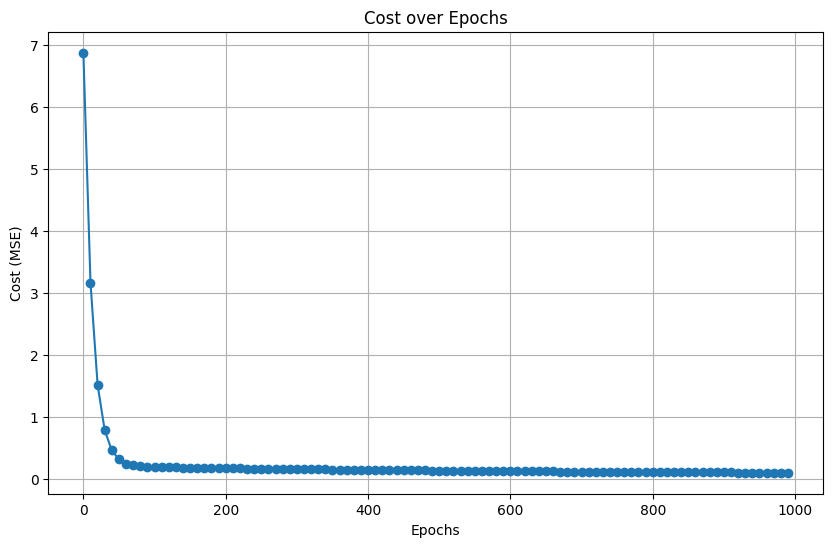

In [33]:
from matplotlib import pyplot as plt
# Plot the cost over epochs
plt.figure(figsize=(10, 6))
plt.plot(epoch_list, cost_list, marker='o', linestyle='-')
plt.title('Cost over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Cost (MSE)')
plt.grid(True)
plt.show()

# **_4. Comparison of Lasso and Ridge Regression using Polynomial Regression_**

## **_Lasso Regression_**

In [37]:
import numpy as np
import pandas as pd

# Load the dataset from the CSV file
diabetes_df = pd.read_csv('first_500_values.csv')

# Assuming you have already scaled the features and target variable
# scaled_X and scaled_y are NumPy arrays


# For example, assuming you have a custom_train_test_split function
# train_X, test_X, train_y, test_y = custom_train_test_split(scaled_X, scaled_y, test_size=0.2, random_state=0)
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    num_samples = X.shape[0]
    num_test_samples = int(test_size * num_samples)
    test_indices = np.random.choice(num_samples, num_test_samples, replace=False)
    train_indices = np.setdiff1d(np.arange(num_samples), test_indices)

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

# Split the data into training and testing sets (you can use your custom split function)
# For example, assuming you have a custom_train_test_split function
train_X, test_X, train_y, test_y = train_test_split(scaled_X, scaled_y, test_size=0.1, random_state=1234)

def cost_function_RR(X,y,w,lamb):
  w1 = np.squeeze(np.asarray(w))
  X1 = np.squeeze(np.asarray(X))
  hypothesis = np.dot(X1,w1.T)
  J = 1/(2*len(y))*np.sum((hypothesis-y)**2)+(lamb/2)*np.sum(w**2)
  return J
# Define the Lasso_SGD and S_gd_Lasso functions (as provided in your previous code)

def S_gd_Lasso(X, y, w, alpha, iters, lamb):
    # Implement the S_gd_Lasso function as provided in your code
    cost_history = np.zeros(iters)
    for i in range(iters):
        rand_index = np.random.randint(len(y))
        ind_x = X[rand_index:rand_index + 1]
        ind_y = y[rand_index:rand_index + 1]

        # Update weights 'w' using Lasso regularization
        gradient = (-2 * ind_x.T.dot(ind_y - ind_x.dot(w))) + (2 * lamb * np.sign(w))
        w = w - alpha * gradient
        cost_history[i] = cost_function_RR(ind_x, ind_y, w, lamb)
    return w, cost_history

def Lasso_SGD(alpha, n_epochs, lamb):
    # Initialize the model weights 'w'
    num_features = train_X.shape[1]
    w = np.zeros((num_features, 1))

    # Call S_gd_Lasso to train the model
    Lasso_SGD_weight, Lasso_SGD_J = S_gd_Lasso(train_X, train_y, w, alpha, n_epochs, lamb)

    # Make predictions on the test set
    Ypred_Lasso_SGD_test = test_X.dot(Lasso_SGD_weight)

    # Make predictions on the test set
    Ypred_Lasso_SGD_train = train_X.dot(Lasso_SGD_weight)

    return Ypred_Lasso_SGD_test,Ypred_Lasso_SGD_train

# # Train the Lasso regression model on the training data
alpha = 0.01  # You may need to adjust this value
n_epochs = 1000  # You may need to adjust the number of epochs
lamb = 0.1  # You may need to adjust the Lasso regularization parameter


# Call Lasso_SGD to get predictions
Ypred_Lasso_SGD_test,Y_pred_Lasso_SGD_train = Lasso_SGD(alpha, n_epochs, lamb)

# Define your threshold for accuracy calculation (you need to define it)
threshold = 0.5


# Calculate accuracy based on your specific definition
accuracy_test = np.mean(np.abs(test_y - Ypred_Lasso_SGD_test) <= threshold)
accuracy_train = np.mean(np.abs(train_y - Y_pred_Lasso_SGD_train) <= threshold)

# Print the accuracy
print(f"Accuracy_train: {accuracy_train:.2%}")
print(f"Accuracy_test: {accuracy_test:.2%}")


Accuracy_train: 91.87%
Accuracy_test: 94.00%


<ipython-input-37-1641fff6eee3>:35: RuntimeWarning: overflow encountered in square
  J = 1/(2*len(y))*np.sum((hypothesis-y)**2)+(lamb/2)*np.sum(w**2)
<ipython-input-37-1641fff6eee3>:49: RuntimeWarning: overflow encountered in multiply
  w = w - alpha * gradient
<ipython-input-37-1641fff6eee3>:49: RuntimeWarning: invalid value encountered in subtract
  w = w - alpha * gradient


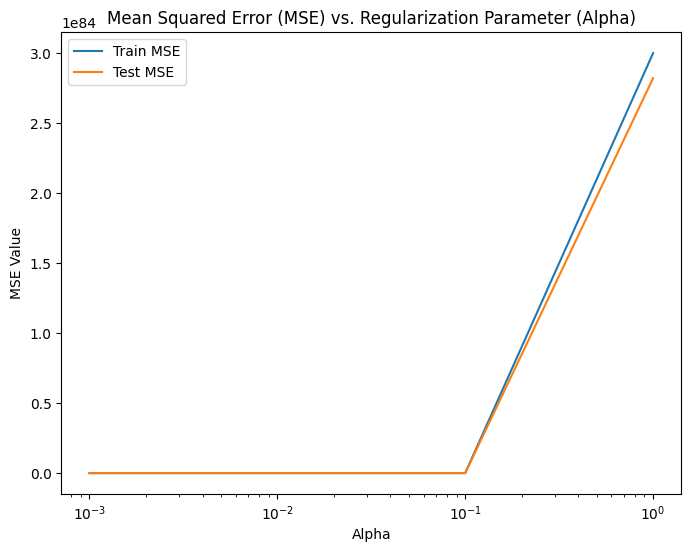

In [58]:

# Initialize a range of regularization parameter values
alphas = [0.001, 0.01, 0.1, 1, 10]

# Initialize empty lists for MSE values
train_mses = []
test_mses = []

for alpha in alphas:
    # Call Lasso_SGD to train the model
    Ypred_Lasso_SGD_test, Ypred_Lasso_SGD_train = Lasso_SGD(alpha, n_epochs, lamb)

    # Calculate MSE for this alpha
    mse_train = ((train_y - Ypred_Lasso_SGD_train) ** 2).mean()
    mse_test = ((test_y - Ypred_Lasso_SGD_test) ** 2).mean()

    # Append these values to the corresponding lists
    train_mses.append(mse_train)
    test_mses.append(mse_test)

# Plot MSE values for different alphas
plt.figure(figsize=(8, 6))
plt.plot(alphas, train_mses, label='Train MSE')
plt.plot(alphas, test_mses, label='Test MSE')
plt.title('Mean Squared Error (MSE) vs. Regularization Parameter (Alpha)')
plt.xlabel('Alpha')
plt.ylabel('MSE Value')
plt.xscale('log')  # Use a logarithmic scale for alpha
plt.legend()
plt.show()



## **_Ridge Regression_**

In [38]:
import numpy as np
import pandas as pd

# Load the dataset from the CSV file
diabetes_df = pd.read_csv('first_500_values.csv')

# Assuming you have already scaled the features and target variable
# scaled_X and scaled_y are NumPy arrays

# Split the data into training and testing sets (you can use your custom split function)
# For example, assuming you have a custom_train_test_split function
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    num_samples = X.shape[0]
    num_test_samples = int(test_size * num_samples)
    test_indices = np.random.choice(num_samples, num_test_samples, replace=False)
    train_indices = np.setdiff1d(np.arange(num_samples), test_indices)

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

# Split the data into training and testing sets (you can use your custom split function)
# For example, assuming you have a custom_train_test_split function
train_X, test_X, train_y, test_y = train_test_split(scaled_X, scaled_y, test_size=0.3, random_state=1234)

# Train the Ridge regression model on the training data
# alpha = 0.01  # You may need to adjust this value
# n_epochs = 1000  # You may need to adjust the number of epochs
# lamb = 0.2  # You may need to adjust the Ridge regularization parameter


# Define the cost function and gradient for Ridge regression

# def S_gd_Ridge(X, y, w, alpha, iters, lamb):
#     cost_history = np.zeros(iters)
#     for i in range(iters):
#         rand_index = np.random.randint(len(y))
#         ind_x = X[rand_index:rand_index + 1]
#         ind_y = y[rand_index:rand_index + 1]

#         ind_x1 = np.squeeze(np.asarray(ind_x))
#         ind_y1 = np.squeeze(np.asarray(ind_y))

#         # Compute the gradient of the mean squared error term
#         gradient_mse = -2 * ind_x1.T.dot(ind_x1.dot(w.T) - ind_y1).T

#         # Compute the gradient of the Ridge regularization term
#         gradient_ridge = 2 * lamb * w

#         # Update the weights with both gradients
#         w = w - alpha * (gradient_mse + gradient_ridge)

#         cost_history[i] = cost_function_RR(ind_x, ind_y, w, lamb)
#     return w, cost_history

# def Ridge_SGD(alpha, n_epochs, lamb):
#     Ridge_SGD_weight, Ridge_SGD_J = S_gd_Ridge(train_X, train_y, w, alpha, n_epochs, lamb)
#     Ypred_Ridge_SGD_train = train_X.dot(Ridge_SGD_weight.T)
#     Ypred_Ridge_SGD_test = test_X.dot(Ridge_SGD_weight.T)
#     return Ypred_Ridge_SGD_train,Ypred_Ridge_SGD_test


# Ypred_Ridge_SGD_test, Ypred_Ridge_SGD_train = Ridge_SGD(alpha, n_epochs, lamb)

def cost_function_Ridge(X, y, w, lamb):
    w1 = np.squeeze(np.asarray(w))
    X1 = np.squeeze(np.asarray(X))
    hypothesis = np.dot(X1, w1.T)
    J = 1 / (2 * len(y)) * np.sum((hypothesis - y) ** 2) + (lamb / (2 * len(y))) * np.sum(w ** 2)
    return J

def gradient_Ridge(X, y, w, lamb):
    # w1 = np.squeeze(np.asarray(w))
    # X1 = np.squeeze(np.asarray(X))
    error = X.dot(w) - y
    gradient = (1 / len(y)) * X.T.dot(error) + (lamb / len(y)) * w
    return gradient.reshape(-1, 1)



# Define the Ridge_SGD and S_gd_Ridge functions

def S_gd_Ridge(X, y, w, alpha, iters, lamb):
    cost_history = np.zeros(iters)
    for i in range(iters):
        rand_index = np.random.randint(len(y))
        ind_x = X[rand_index:rand_index + 1]
        ind_y = y[rand_index:rand_index + 1]

        # Calculate the gradient using Ridge regularization
        gradient = gradient_Ridge(ind_x, ind_y, w, lamb)

        # Update weights 'w'
        w = w - alpha * gradient
        cost_history[i] = cost_function_Ridge(ind_x, ind_y, w, lamb)
    return w, cost_history

def Ridge_SGD(alpha, n_epochs, lamb):
    # Initialize the model weights 'w'
    num_features = train_X.shape[1]
    w = np.zeros((num_features, 1))

    # Call S_gd_Ridge to train the model
    Ridge_SGD_weight, Ridge_SGD_J = S_gd_Ridge(train_X, train_y, w, alpha, n_epochs, lamb)

    # Make predictions on the test set
    Ypred_Ridge_SGD_test = test_X.dot(Ridge_SGD_weight)
    Ypred_Ridge_SGD_train = train_X.dot(Ridge_SGD_weight)

    return Ypred_Ridge_SGD_test, Ypred_Ridge_SGD_train



# Call Ridge_SGD to get predictions
Ypred_Ridge_SGD_test, Ypred_Ridge_SGD_train = Ridge_SGD(alpha, n_epochs, lamb)


# Define your threshold for accuracy calculation (you need to define it)
threshold = 0.5

# Calculate accuracy based on your specific definition
accuracy_test = np.mean(np.abs(test_y - Ypred_Ridge_SGD_test) <= threshold)
accuracy_train = np.mean(np.abs(train_y - Ypred_Ridge_SGD_train) <= threshold)

# Print the accuracy
print(f"Accuracy_train: {accuracy_train:.2%}")
print(f"Accuracy_test: {accuracy_test:.2%}")

Accuracy_train: 92.94%
Accuracy_test: 90.07%


## **_Insights drawn (plots, markdown explanations)_**

Epoch 1000/1000 - MSE Train: 0.0639, MSE Test: 0.0893, R-squared Train: 0.0268, R-squared Test: 0.0021


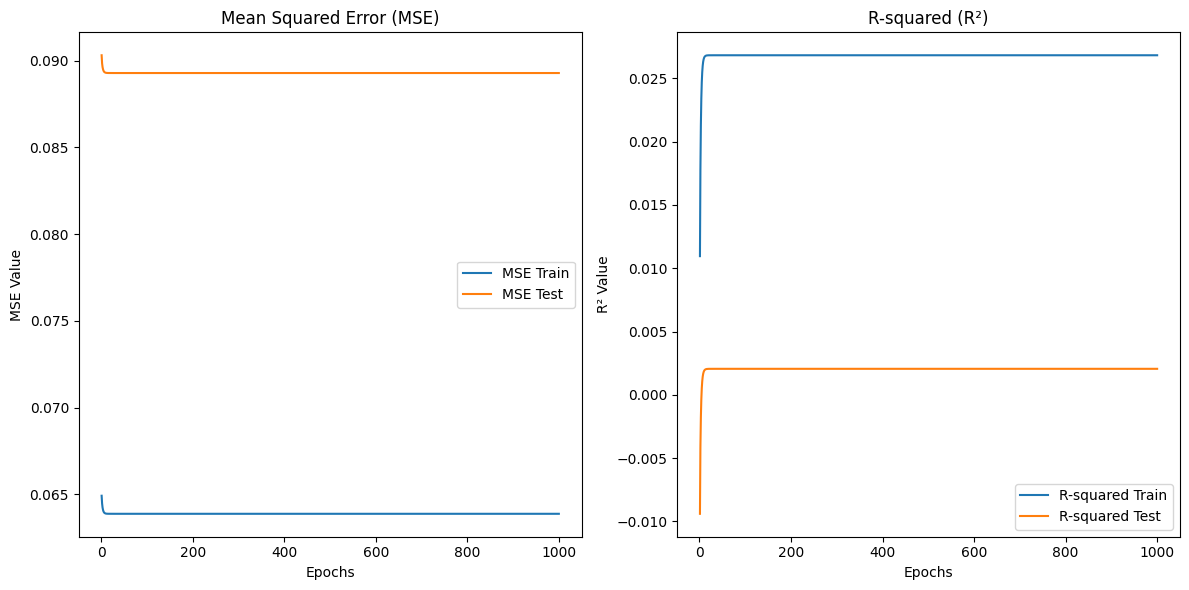

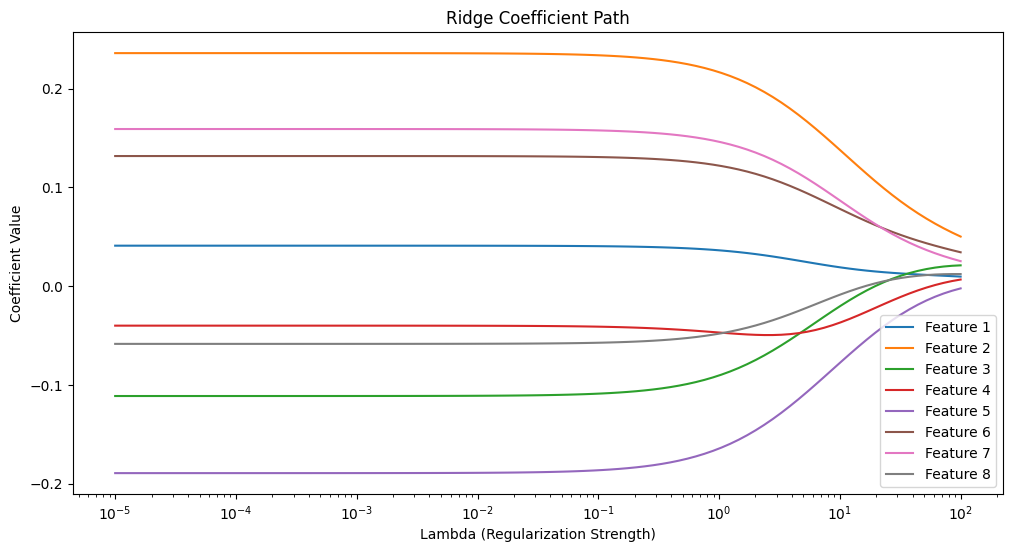

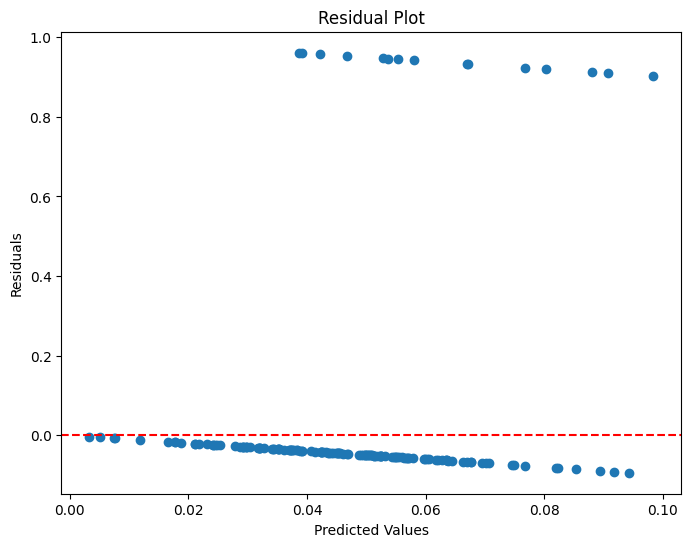

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# ... (previous code)

# Initialize empty lists for MSE and R-squared values
mse_train_values = []
mse_test_values = []
r_squared_train_values = []
r_squared_test_values = []

def calculate_mse(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

def calculate_r_squared(y_true, y_pred):
    y_mean = np.mean(y_true)
    ss_total = ((y_true - y_mean) ** 2).sum()
    ss_residual = ((y_true - y_pred) ** 2).sum()
    r_squared = 1 - (ss_residual / ss_total)
    return r_squared

def Ridge_SGD(alpha, n_epochs, lamb):
    # Initialize the model weights 'w'
    num_features = train_X.shape[1]
    w = np.zeros((num_features, 1))

    for epoch in range(n_epochs):
        for i in range(len(train_y)):
            ind_x = train_X[i:i + 1]
            ind_y = train_y[i:i + 1]

            # Calculate the gradient using Ridge regularization
            gradient = gradient_Ridge(ind_x, ind_y, w, lamb)

            # Update weights 'w'
            w = w - alpha * gradient

        # Make predictions on the test set
        Ypred_Ridge_SGD_test = test_X.dot(w)
        Ypred_Ridge_SGD_train = train_X.dot(w)

        # Calculate MSE and R-squared values for this epoch
        mse_train = calculate_mse(train_y, Ypred_Ridge_SGD_train)
        mse_test = calculate_mse(test_y, Ypred_Ridge_SGD_test)
        r_squared_train = calculate_r_squared(train_y, Ypred_Ridge_SGD_train)
        r_squared_test = calculate_r_squared(test_y, Ypred_Ridge_SGD_test)

        # Append these values to the corresponding lists
        mse_train_values.append(mse_train)
        mse_test_values.append(mse_test)
        r_squared_train_values.append(r_squared_train)
        r_squared_test_values.append(r_squared_test)

        # Print progress
        if (epoch + 1)  == 1000:
            print(f"Epoch {epoch + 1}/{n_epochs} - MSE Train: {mse_train:.4f}, MSE Test: {mse_test:.4f}, R-squared Train: {r_squared_train:.4f}, R-squared Test: {r_squared_test:.4f}")

    return Ypred_Ridge_SGD_test, Ypred_Ridge_SGD_train

# Call Ridge_SGD to get predictions
Ypred_Ridge_SGD_test, Ypred_Ridge_SGD_train = Ridge_SGD(alpha, n_epochs, lamb)

# ... (rest of the code for plotting)

# Now, create the epochs array with the correct dimension
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, mse_train_values, label='MSE Train')
plt.plot(epochs, mse_test_values, label='MSE Test')
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Epochs')
plt.ylabel('MSE Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, r_squared_train_values, label='R-squared Train')
plt.plot(epochs, r_squared_test_values, label='R-squared Test')
plt.title('R-squared (R²)')
plt.xlabel('Epochs')
plt.ylabel('R² Value')
plt.legend()

plt.tight_layout()
plt.show()

def ridge_coefficient_path(X, y, lambdas):
    coefs = []
    for lamb in lambdas:
        w = np.linalg.inv(X.T @ X + lamb * np.identity(X.shape[1])) @ X.T @ y
        coefs.append(w)
    return np.array(coefs)

# Define a range of lambda values
lambdas = np.logspace(-5, 2, 100)

# Calculate the coefficient path
coefs = ridge_coefficient_path(train_X, train_y, lambdas)

# Plot the coefficient path
plt.figure(figsize=(12, 6))
for i in range(train_X.shape[1]):
    plt.plot(lambdas, coefs[:, i], label=f'Feature {i + 1}')
plt.xscale('log')
plt.title('Ridge Coefficient Path')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()



# Calculate residuals
residuals = test_y - Ypred_Ridge_SGD_test

plt.figure(figsize=(8, 6))
plt.scatter(Ypred_Ridge_SGD_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()




Epoch 1000/1000 - Train MSE: 0.0639, Test MSE: 0.0893


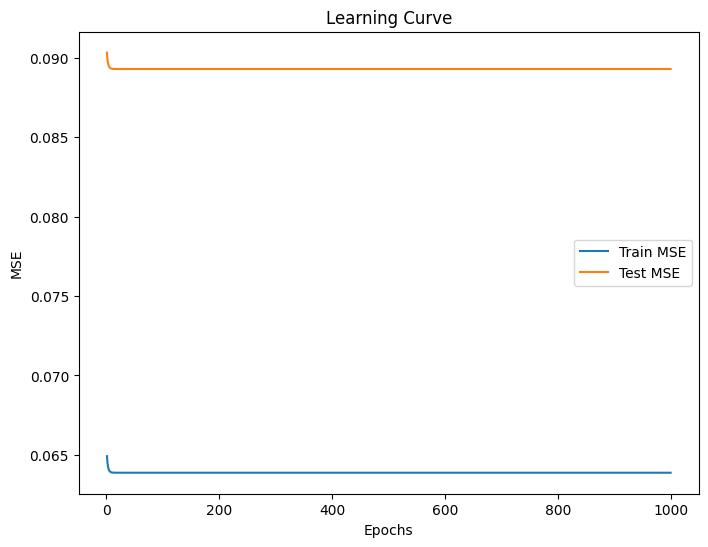

In [41]:
# Initialize empty lists for MSE values
mse_train_values = []
mse_test_values = []

def Ridge_SGD(alpha, n_epochs, lamb):
    # Initialize the model weights 'w'
    num_features = train_X.shape[1]
    w = np.zeros((num_features, 1))

    for epoch in range(n_epochs):
        for i in range(len(train_y)):
            ind_x = train_X[i:i + 1]
            ind_y = train_y[i:i + 1]

            # Calculate the gradient using Ridge regularization
            gradient = gradient_Ridge(ind_x, ind_y, w, lamb)

            # Update weights 'w'
            w = w - alpha * gradient

        # Make predictions on the test set
        Ypred_Ridge_SGD_test = test_X.dot(w)
        Ypred_Ridge_SGD_train = train_X.dot(w)

        # Calculate MSE values for this epoch
        mse_train = calculate_mse(train_y, Ypred_Ridge_SGD_train)
        mse_test = calculate_mse(test_y, Ypred_Ridge_SGD_test)

        # Append these values to the corresponding lists
        mse_train_values.append(mse_train)
        mse_test_values.append(mse_test)

        # Print progress
        if (epoch + 1)  == 1000:
            print(f"Epoch {epoch + 1}/{n_epochs} - Train MSE: {mse_train:.4f}, Test MSE: {mse_test:.4f}")

    return Ypred_Ridge_SGD_test, Ypred_Ridge_SGD_train

# Call Ridge_SGD to get predictions
Ypred_Ridge_SGD_test, Ypred_Ridge_SGD_train = Ridge_SGD(alpha, n_epochs, lamb)

# Now, create the epochs array with the correct dimension
epochs = range(1, n_epochs + 1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(epochs, mse_train_values, label='Train MSE')
plt.plot(epochs, mse_test_values, label='Test MSE')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()


# **_5. Comparison of Logistic Regression and Least Squares Classification_**

## **_Logistic Regression_**

In [63]:
# import numpy as np
# import pandas as pd

# class LogisticRegression:
#     def __init__(self, learning_rate=0.01, n_iterations=1000):
#         self.learning_rate = learning_rate
#         self.n_iterations = n_iterations

#     def sigmoid(self, z):
#         return 1 / (1 + np.exp(-z))

#     def fit(self, X, y):
#         self.m, self.n = X.shape
#         self.weights = np.zeros(self.n)
#         self.bias = 0

#         for _ in range(self.n_iterations):
#             linear_model = np.dot(X, self.weights) + self.bias
#             y_pred = self.sigmoid(linear_model)

#             dw = (1 / self.m) * np.dot(X.T, (y_pred - y))
#             db = (1 / self.m) * np.sum(y_pred - y)

#             self.weights -= self.learning_rate * dw
#             self.bias -= self.learning_rate * db

#     def predict(self, X):
#         linear_model = np.dot(X, self.weights) + self.bias
#         y_pred = self.sigmoid(linear_model)
#         y_pred_class = [1 if i > 0.5 else 0 for i in y_pred]
#         return y_pred_class

# # Load the diabetes dataset
# diabetes_dataset = pd.read_csv('first_500_values.csv')

# # Separate the data and labels
# features = diabetes_dataset.drop(columns='Outcome', axis=1)
# target = diabetes_dataset['Outcome']

# # Mean normalization and standardization
# mean = features.mean()
# std = features.std()
# features = (features - mean) / std

# # Split the dataset
# from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=1224)
# print(features.shape, X_train.shape, X_test.shape)

# # Create an instance of the LogisticRegression class
# classifier = LogisticRegression(learning_rate=0.01, n_iterations=1000)

# # Train the model
# classifier.fit(X_train, Y_train)

# # Accuracy score on the training data
# X_train_prediction = classifier.predict(X_train)
# training_data_accuracy = np.mean(X_train_prediction == Y_train)
# print('Accuracy score of the training data: ', training_data_accuracy)

# # Accuracy score on the test data
# X_test_prediction = classifier.predict(X_test)
# test_data_accuracy = np.mean(X_test_prediction == Y_test)
# print('Accuracy score of the test data: ', test_data_accuracy)

#####################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class LogisticRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.cost_history = []  # To store the cost at each iteration

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        self.m, self.n = X.shape
        self.weights = np.zeros(self.n)
        self.bias = 0

        for _ in range(self.n_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)

            dw = (1 / self.m) * np.dot(X.T, (y_pred - y))
            db = (1 / self.m) * np.sum(y_pred - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Calculate and store the cost at each iteration
            cost = (-1 / self.m) * (y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).sum()
            self.cost_history.append(cost)

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(linear_model)
        y_pred_class = [1 if i > 0.5 else 0 for i in y_pred]
        return y_pred_class

# Load the diabetes dataset
diabetes_df = pd.read_csv('first_500_values.csv')

# Separate the data and labels
features = diabetes_df.drop(columns='Outcome', axis=1)
target = diabetes_df['Outcome']

# Mean normalization and standardization
mean = features.mean()
std = features.std()
features = (features - mean) / std

# Split the dataset
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    num_samples = X.shape[0]
    num_test_samples = int(test_size * num_samples)
    test_indices = np.random.choice(num_samples, num_test_samples, replace=False)
    train_indices = np.setdiff1d(np.arange(num_samples), test_indices)

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

X_train, X_test, Y_train, Y_test = train_test_split(features.to_numpy(), target.to_numpy(), test_size=0.2, random_state=1224)

# Create an instance of the LogisticRegression class
classifier = LogisticRegression(learning_rate=0.01, n_iterations=1000)

# Train the model
classifier.fit(X_train, Y_train)

# Accuracy score on the training data
X_train_prediction = classifier.predict(X_train)
training_data_accuracy = np.mean(X_train_prediction == Y_train)
print('Accuracy score of the training data: ', training_data_accuracy)

# Accuracy score on the test data
X_test_prediction = classifier.predict(X_test)
test_data_accuracy = np.mean(X_test_prediction == Y_test)
print('Accuracy score of the test data: ', test_data_accuracy)




Accuracy score of the training data:  0.9183168316831684
Accuracy score of the test data:  0.9405940594059405


## **_Insights drawn (plots, markdown explanations)_**

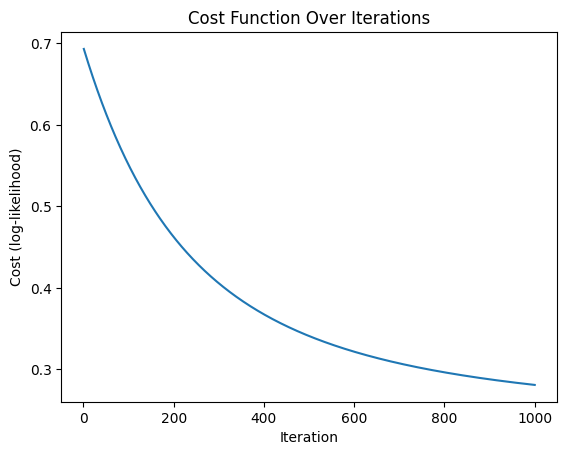

In [62]:
# Plot the cost function over iterations
plt.plot(range(1, classifier.n_iterations + 1), classifier.cost_history)
plt.xlabel('Iteration')
plt.ylabel('Cost (log-likelihood)')
plt.title('Cost Function Over Iterations')
plt.show()

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


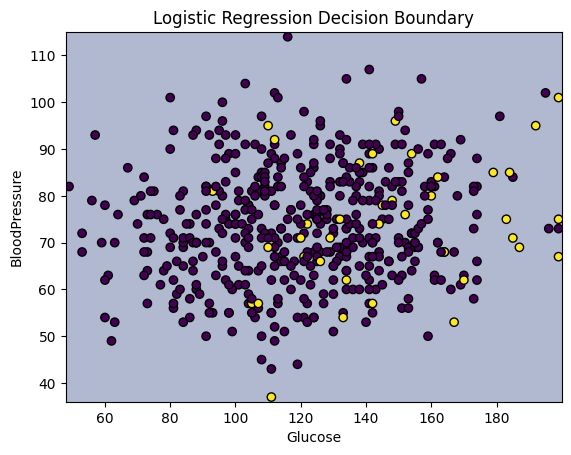

<ipython-input-42-829ee045e635>:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


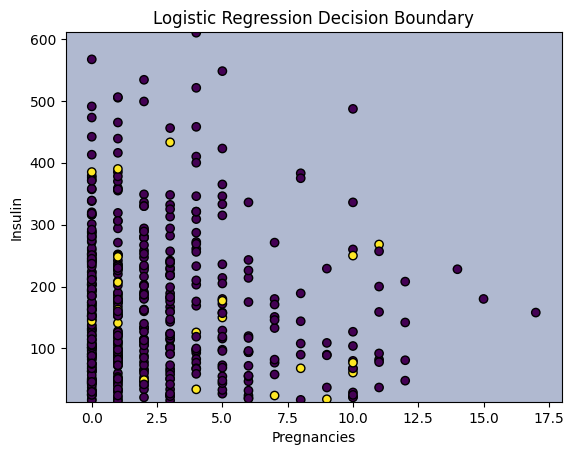

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the diabetes dataset
diabetes_dataset = pd.read_csv('first_500_values.csv')

# Select two features (for example, 'Glucose' and 'BloodPressure')
X = diabetes_dataset[['Glucose', 'BloodPressure']].values
y = diabetes_dataset['Outcome'].values

# Create an instance of the LogisticRegression class
classifier = LogisticRegression(learning_rate=0.01, n_iterations=1000)

# Train the model
classifier.fit(X, y)

# Define a meshgrid of points for the decision boundary plot
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict the class labels for the meshgrid points
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.array(Z)  # Convert Z to a NumPy array
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, marker='o', edgecolor='k')
plt.xlabel('Glucose')
plt.ylabel('BloodPressure')
plt.title('Logistic Regression Decision Boundary')
plt.show()

# Select two features (for example, 'Pregnancies' and 'Insulin')
X1 = diabetes_dataset[['Pregnancies', 'Insulin']].values
y1 = diabetes_dataset['Outcome'].values



# Train the model
classifier.fit(X1, y1)

# Define a meshgrid of points for the decision boundary plot
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict the class labels for the meshgrid points
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.array(Z)  # Convert Z to a NumPy array
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X1[:, 0], X1[:, 1], c=y1, marker='o', edgecolor='k')
plt.xlabel('Pregnancies')
plt.ylabel('Insulin')
plt.title('Logistic Regression Decision Boundary')
plt.show()







## **_Least Squares Classification_**

In [44]:
import numpy as np
import pandas as pd

# Load the dataset from the CSV file
diabetes_df = pd.read_csv('first_500_values.csv')

# Assuming you have already scaled the features and target variable
# scaled_X and scaled_y are NumPy arrays
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    num_samples = X.shape[0]
    num_test_samples = int(test_size * num_samples)
    test_indices = np.random.choice(num_samples, num_test_samples, replace=False)
    train_indices = np.setdiff1d(np.arange(num_samples), test_indices)

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

# Split the data into training and testing sets (you can use your custom split function)
# For example, assuming you have a custom_train_test_split function
train_X, test_X, train_y, test_y = train_test_split(scaled_X, scaled_y, test_size=0.2, random_state=0)

# Define the least squares classification function
def least_squares_classification(X, y):
    XTX = np.dot(X.T, X)
    XTy = np.dot(X.T, y)
    w = np.linalg.solve(XTX, XTy)
    return w



# Train the model using the training data
w = least_squares_classification(train_X, train_y)

# Define a function to calculate Mean Squared Error (MSE)
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Define a function to calculate accuracy
# def accuracy(y_true, y_pred):
#     return np.mean(y_true == y_pred)


def calculate_confusion_matrix(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return TP, TN, FP, FN

# Predict using the trained model
train_y_pred = np.round(np.dot(train_X, w))
test_y_pred = np.round(np.dot(test_X, w))

# Calculate confusion matrix components for training and testing
train_TP, train_TN, train_FP, train_FN = calculate_confusion_matrix(train_y, train_y_pred)
test_TP, test_TN, test_FP, test_FN = calculate_confusion_matrix(test_y, test_y_pred)

# Calculate accuracy for training and testing using the confusion matrix components
train_accuracy = (train_TP + train_TN) / (train_TP + train_TN + train_FP + train_FN)
test_accuracy = (test_TP + test_TN) / (test_TP + test_TN + test_FP + test_FN)



# Calculate Mean Squared Error (MSE) for training and testing
train_mse = mean_squared_error(train_y, train_y_pred)
test_mse = mean_squared_error(test_y, test_y_pred)

# # Calculate accuracy for training and testing
# train_acc = accuracy(train_y, train_y_pred)
# test_acc = accuracy(test_y, test_y_pred)

# Print the results
print(f"Training MSE: {train_mse:.2f}")
print(f"Testing MSE: {test_mse:.2f}")
print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Testing Accuracy: {test_accuracy:.2%}")


Training MSE: 0.08
Testing MSE: 0.06
Training Accuracy: 91.58%
Testing Accuracy: 94.06%


## **_Insights drawn (plots, markdown explanations)_**

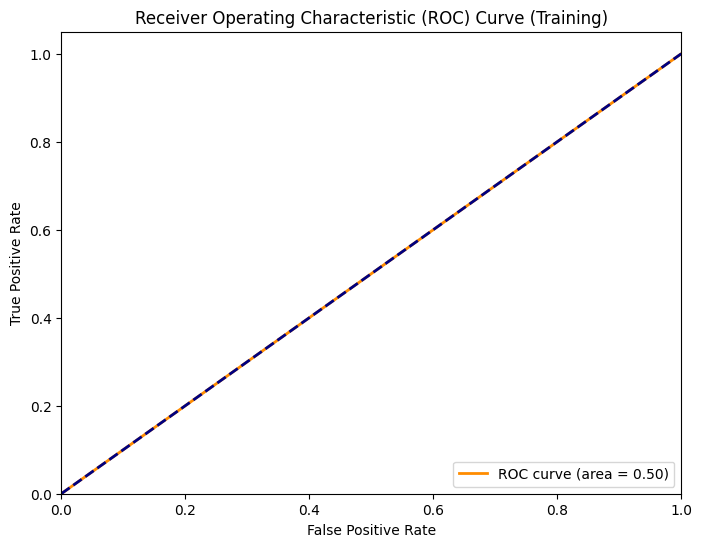

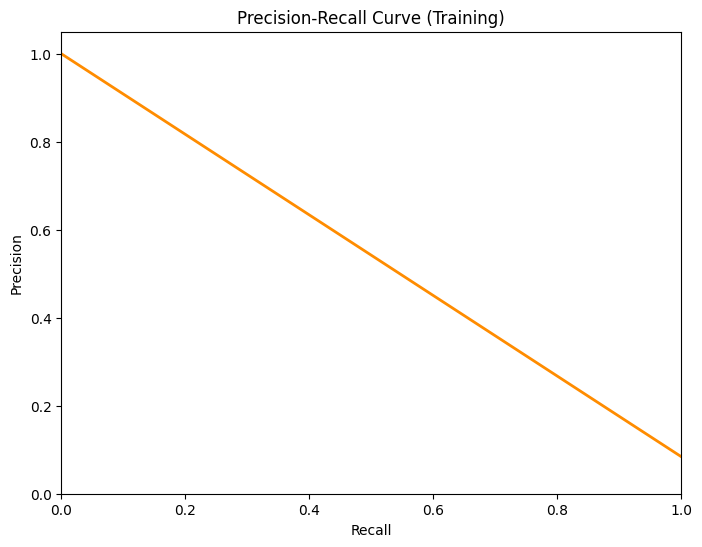

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc


# ROC Curve
fpr_train, tpr_train, _ = roc_curve(train_y, train_y_pred)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_train))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Training)')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision_train, recall_train, _ = precision_recall_curve(train_y, train_y_pred)

plt.figure(figsize=(8, 6))
plt.plot(recall_train, precision_train, color='darkorange', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Training)')
plt.show()


# **_5. References_**

1.   https://docs.sdv.dev/sdv/
2.   https://www.youtube.com/watch?v=DeUAvYyB0Os&list=PLfFghEzKVmjsF8ixJ-xKVuQayPWRH4Sp6&index=6
3.   https://www.youtube.com/watch?v=IU5fuoYBTAM

